# Step 0 - import relation module

In [1]:
%matplotlib inline
import os,sys
import datacube
from datacube.config import LocalConfig
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sys.path.append(os.environ['odc_config'])
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')
#import 會用到的模組

# Step 1 - loading image


In [2]:
base_lat = 22.98322
base_lon = 120.22082

#base_lat、base_lon代表要取的那點的座標

lon = (base_lon + 0.001, base_lon - 0.001)
lat = (base_lat + 0.001, base_lat - 0.001)

#將經緯度範圍設定為+-0.001的範圍

date_range =(datetime.datetime(2010,1,1), datetime.datetime(2019,12,31))

platform = 'LANDSAT_8'
product = 'ls8_C1_sr_taiwan'  

desired_bands = ['red','green','blue','nir','swir1','swir2','pixel_qa']  

#取出資料
landsat = dc.load(product = product,platform = platform,lat = lat,lon = lon, time = date_range,measurements = desired_bands,group_by = 'solar_day')

# Step 2 - extract data according to coordinates and filter by pixel quality

In [3]:
pixel_coordinates = {"latitude":base_lat,"longitude": base_lon}
pixel = landsat.sel(**pixel_coordinates, method = 'nearest')
#根據坐標取出資料

In [4]:
point = pixel.where(pixel.pixel_qa == 322)
#篩選pixel_qa為322的資料出來

# Step 3 - get ndvi values

In [5]:
ndvi = (point.nir - point.red)/(point.nir + point.red)
#計算ndvi

# Step 4 - output to pandas dataframe

In [6]:
result = pd.DataFrame({'time':ndvi.time.values})
result['ndvi'] = ndvi.values
#做成表格

In [7]:
result = result[~result['ndvi'].isin(['NaN'])]

# Step 5 - plot ndvi values by time

In [8]:
#計算繪圖用資料
result2 = pd.DataFrame({'time':ndvi.time.values})
result2['ndvi'] = ndvi.values
result2 = result2[~result2['ndvi'].isin(['NaN'])]

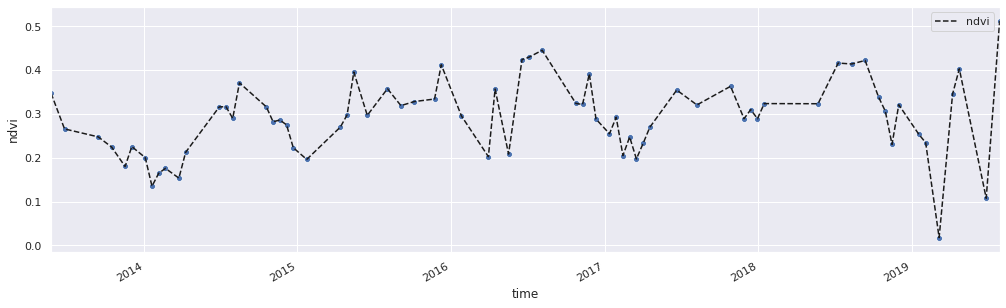

In [9]:
#用seaborn繪製散布圖
sns.set()
plt.subplots(figsize=(17,5))
result.set_index("time")['ndvi'].plot(style='k--')
sns.scatterplot(x="time", y="ndvi", data=result2)
#根據時間繪圖

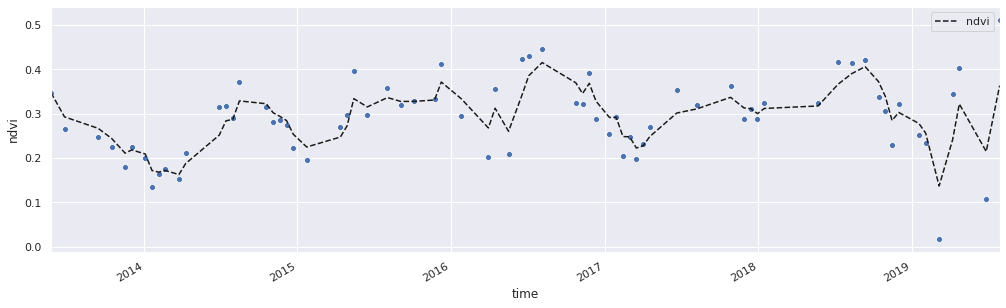

In [10]:
#指數加權函數分析
import time
sns.set()
plt.subplots(figsize=(17,5))
plt.xlim(pd._libs.tslib.Timestamp('2013-01-01 00:00:00'), pd._libs.tslib.Timestamp('2020-01-01 00:00:00')) 

test = result2.set_index("time")['ndvi'].rolling(window=60,min_periods=50).mean()
#套用指數分析
ewma60 = result2.set_index("time")['ndvi'].ewm(span=3).mean()
ewma60.plot(style='k--')

sns.scatterplot(x="time", y="ndvi", data=result2)


# Step 6 - output to csv

In [11]:
result.to_csv('ndvi_value.csv',index=True,sep=',')
#輸出成csv檔

# Step 7 - iteration processing

In [2]:
#讀入csv檔案
point_list = pd.read_csv('test_tree.csv')
point_list

,編號,樹種,株數,區別,座落地點,樹高(m),胸圍(m),樹齡(104年),樹冠面積 (m2),樹冠直徑,緯度,經度,97座標X,97座標Y
0,1,苦楝,1,東區,原農業試驗場,15.00,3.17,80,418.83,23.098515,22.983223,120.220815,170112.083,2542645.776
1,2,盾柱木,1,北區,臺南公園(近公園路側),20.00,2.60,60,130.00,12.868764,23.001448,120.209795,168993.349,2544661.754
2,3,茄苳,1,北區,臺南公園(近公園路側),12.95,2.76,80,223.00,16.854567,23.001192,120.210321,169047.121,2544633.114
3,4,菩提樹,1,北區,臺南公園(近公園路側),26.00,7.77,110,729.29,30.480024,23.000752,120.211225,169139.535,2544583.890
4,5,瓊崖海棠,1,北區,臺南公園(近公園路側),14.50,2.16,50,240.00,17.485208,23.000494,120.211166,169133.333,2544555.351
5,6,雨豆樹,1,北區,臺南公園(近公園路側),23.00,5.92,100,740.68,30.717119,23.000510,120.211615,169179.373,2544556.876
6,7,茄苳,1,北區,臺南公園(燕潭旁),13.00,2.78,60,112.10,11.950002,23.001088,120.211660,169184.330,2544620.859
7,50,鐵刀木,1,北區,臺南公園(北門路與公園南路交叉處 ),17.00,2.30,60,189.00,15.516582,23.000294,120.212666,169286.992,2544532.377


In [3]:
#設定參數
lon_list = point_list['經度'].values #經度清單
lat_list = point_list['緯度'].values #緯度清單
index_list = point_list['編號'].values #樹木編號清單

date_range =(datetime.datetime(2010,1,1), datetime.datetime(2019,12,31))

platform = 'LANDSAT_8'
product = 'ls8_C1_sr_taiwan'  

desired_bands = ['red','green','blue','nir','swir1','swir2','pixel_qa']  

In [7]:
count = 1
if not os.path.isdir('./ndvi_result/'): #建立名為ndvi_result的資料夾
    os.mkdir(path)

for base_lat,base_lon,index in zip(lat_list,lon_list,index_list): #迴圈處理
    lon = (base_lon + 0.001, base_lon - 0.001)
    lat = (base_lat + 0.001, base_lat - 0.001)
    landsat = dc.load(product = product,platform = platform,lat = lat,lon = lon, time = date_range,measurements = desired_bands,group_by = 'solar_day')
    pixel_coordinates = {"latitude":base_lat,"longitude": base_lon}
    pixel = landsat.sel(**pixel_coordinates, method = 'nearest')
    point = pixel.where(pixel.pixel_qa == 322)
    ndvi = (point.nir - point.red)/(point.nir + point.red)
    result = pd.DataFrame({'time':ndvi.time.values})
    result['ndvi'] = ndvi.values
    result = result[~result['ndvi'].isin(['NaN'])]
    result.to_csv('./ndvi_result/' + str(index) + '.csv',index=True,sep=',')
    print(index) #印出執行完成的編號

1
2
3
4
5
6
7
50


In [8]:
import shutil
zip_name = 'ndvi_result' #壓縮檔名
directory_name = "./ndvi_result/"
shutil.make_archive(zip_name, 'zip', directory_name) #壓縮檔案

'/home/h920032/ndvi_result.zip'

# Step 8 output to one excel file

In [2]:
!pip3 install xlrd --user #如果有安裝過可以不用執行

In [ ]:
!pip3 install openpyxl==3.0.1 --user #如果有安裝過可以不用執行

1
2
3
4
5
6
7
50


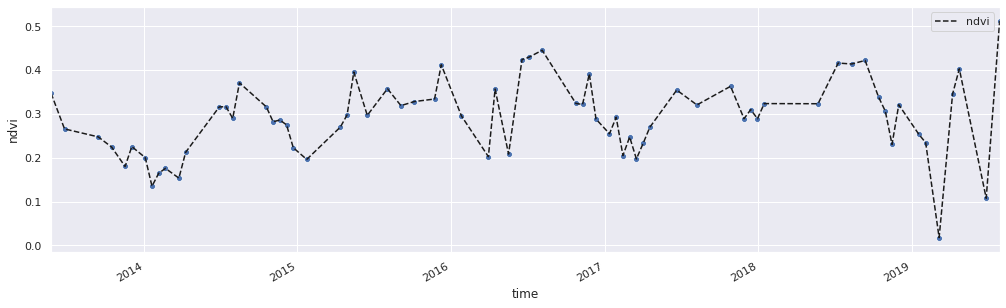

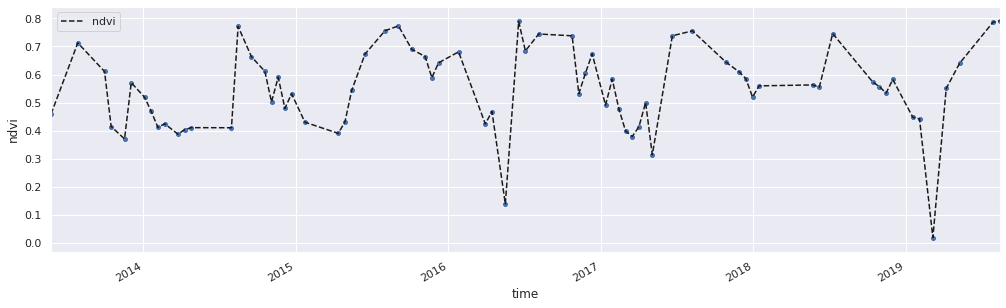

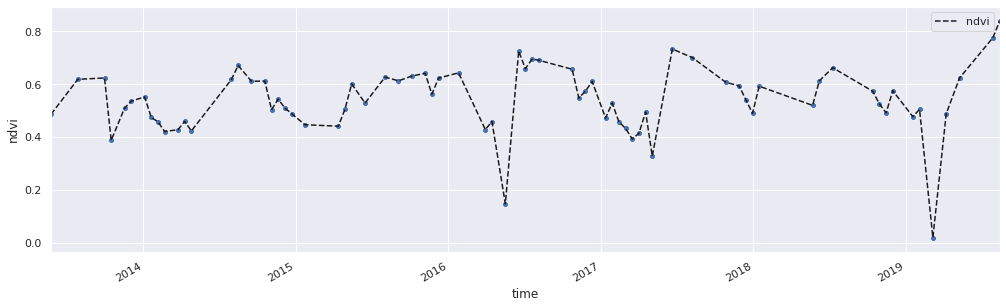

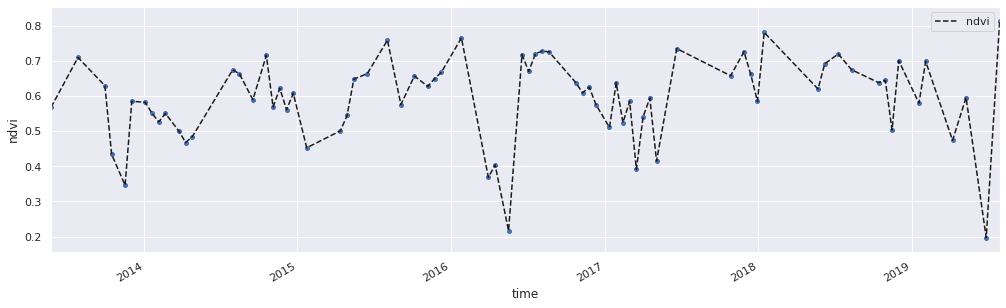

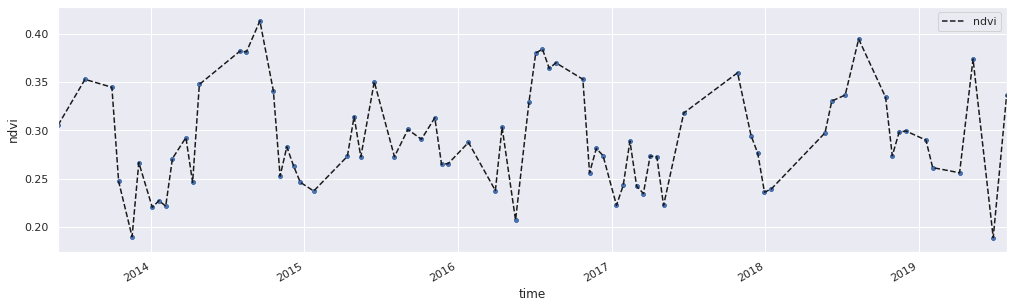

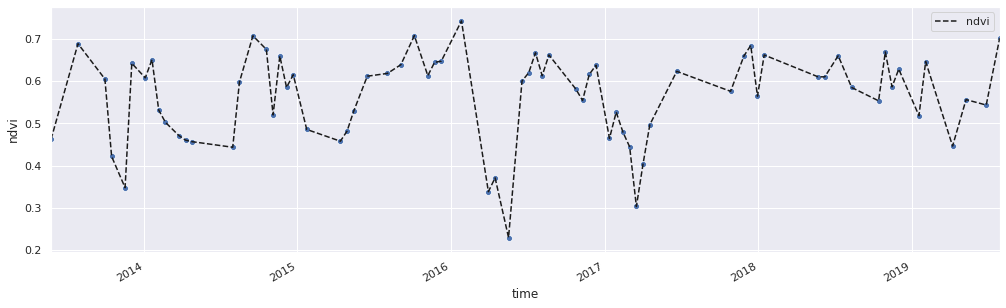

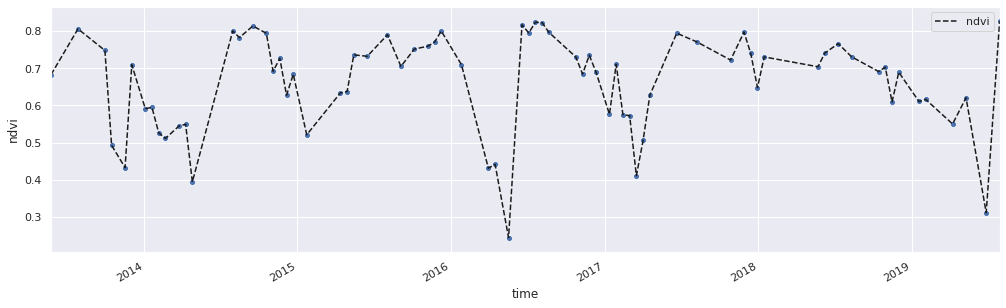

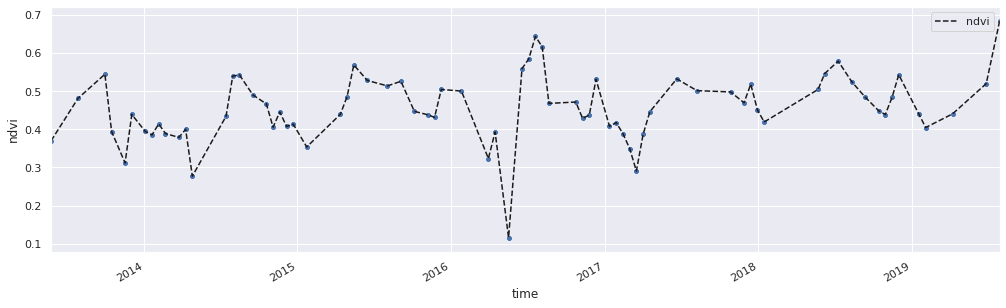

In [2]:
#===========import 會用到的模組=================
%matplotlib inline
import os,sys
import datacube
from datacube.config import LocalConfig
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
sys.path.append(os.environ['odc_config'])
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

#=================設定參數=====================
point_list = pd.read_csv('test_tree.csv')

lon_list = point_list['經度'].values #經度清單
lat_list = point_list['緯度'].values #緯度清單
index_list = point_list['編號'].values #樹木編號清單

date_range =(datetime.datetime(2010,1,1), datetime.datetime(2019,12,31))

platform = 'LANDSAT_8'
product = 'ls8_C1_sr_taiwan'  

desired_bands = ['red','green','blue','nir','swir1','swir2','pixel_qa']  

if not os.path.isdir('./ndvi_result/'): #建立名為ndvi_result的資料夾
    os.mkdir('./ndvi_result/')

#=================抓取資料=====================
count = 1
with pd.ExcelWriter('ndvi_result.xlsx') as writer:
    for base_lat,base_lon,index in zip(lat_list,lon_list,index_list): #迴圈處理
        lon = (base_lon + 0.001, base_lon - 0.001)
        lat = (base_lat + 0.001, base_lat - 0.001)
        landsat = dc.load(product = product,platform = platform,lat = lat,lon = lon, time = date_range,measurements = desired_bands,group_by = 'solar_day')
        #取出piexl
        pixel_coordinates = {"latitude":base_lat,"longitude": base_lon}
        pixel = landsat.sel(**pixel_coordinates, method = 'nearest')
        point = pixel.where(pixel.pixel_qa == 322)
        ndvi = (point.nir - point.red)/(point.nir + point.red)
        result = pd.DataFrame({'time':ndvi.time.values})
        result['ndvi'] = ndvi.values
        result = result[~result['ndvi'].isin(['NaN'])]
        result.to_excel(writer, sheet_name='NO.' + str(index))
        
        #計算繪圖用資料
        result2 = pd.DataFrame({'time':ndvi.time.values})
        result2['ndvi'] = ndvi.values
        result2 = result2[~result2['ndvi'].isin(['NaN'])]
        
        sns.set()
        plt.subplots(figsize=(17,5))
        result.set_index("time")['ndvi'].plot(style='k--')
        sns.scatterplot(x="time", y="ndvi", data=result2)
        
        plt.savefig('./ndvi_result/' + str(index) + '.png')
        print(index) #印出執行完成的編號

zip_name = 'ndvi_result_png' #壓縮檔名
directory_name = "./ndvi_result/"
shutil.make_archive(zip_name, 'zip', directory_name) #壓縮檔案